# USD/JPY LSTM(TensorFlow)

In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set()

## データ読み込み

In [22]:
!mkdir data
!wget https://dl.dropbox.com/s/rzzcc89lokvzu3r/usd_jpy.csv -O data/usd_jpy.csv

mkdir: cannot create directory ‘data’: File exists
--2020-10-18 00:16:01--  https://dl.dropbox.com/s/rzzcc89lokvzu3r/usd_jpy.csv
Resolving dl.dropbox.com (dl.dropbox.com)... 162.125.65.15, 2620:100:6021:15::a27d:410f
Connecting to dl.dropbox.com (dl.dropbox.com)|162.125.65.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/s/rzzcc89lokvzu3r/usd_jpy.csv [following]
--2020-10-18 00:16:01--  https://dl.dropboxusercontent.com/s/rzzcc89lokvzu3r/usd_jpy.csv
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.15, 2620:100:6021:15::a27d:410f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107599 (105K) [text/csv]
Saving to: ‘data/usd_jpy.csv’

data/usd_jpy.csv    100%[===================>] 105.08K   467KB/s    in 0.2s    

2020-10-18 00:16:02 (467 KB/s) - ‘data/usd_jpy.csv’ saved [107599/107599]



In [23]:
df = pd.read_csv('data/usd_jpy.csv')
df.head()

,日付,始値,高値,安値,終値
0,2007/04/02,117.84,118.08,117.46,117.84
1,2007/04/03,117.84,118.98,117.72,118.96
2,2007/04/04,118.92,119.08,118.56,118.72
3,2007/04/05,118.72,118.99,118.44,118.72
4,2007/04/06,118.72,119.39,118.67,119.27


In [24]:
df.describe()

,始値,高値,安値,終値
count,2925.000000,2925.000000,2925.000000,2925.000000
mean,100.618236,101.057046,100.119538,100.615289
std,13.849288,13.881241,13.800449,13.851496
min,75.760000,75.980000,75.570000,75.680000
25%,89.690000,90.210000,89.120000,89.740000
50%,102.080000,102.440000,101.720000,102.090000
75%,111.700000,112.140000,111.170000,111.700000
max,125.660000,125.860000,124.540000,125.550000


([<matplotlib.axis.XTick at 0x7fd1b9fb2c18>,
 [Text(0, 0, '2007/04/02'),
  Text(0, 0, '2008/04/02'),
  Text(0, 0, '2009/04/03'),
  Text(0, 0, '2010/04/05'),
  Text(0, 0, '2011/04/04'),
  Text(0, 0, '2012/04/03'),
  Text(0, 0, '2013/04/03'),
  Text(0, 0, '2014/04/03'),
  Text(0, 0, '2015/04/03'),
  Text(0, 0, '2016/04/04'),
  Text(0, 0, '2017/04/04'),
  Text(0, 0, '2018/04/04')])

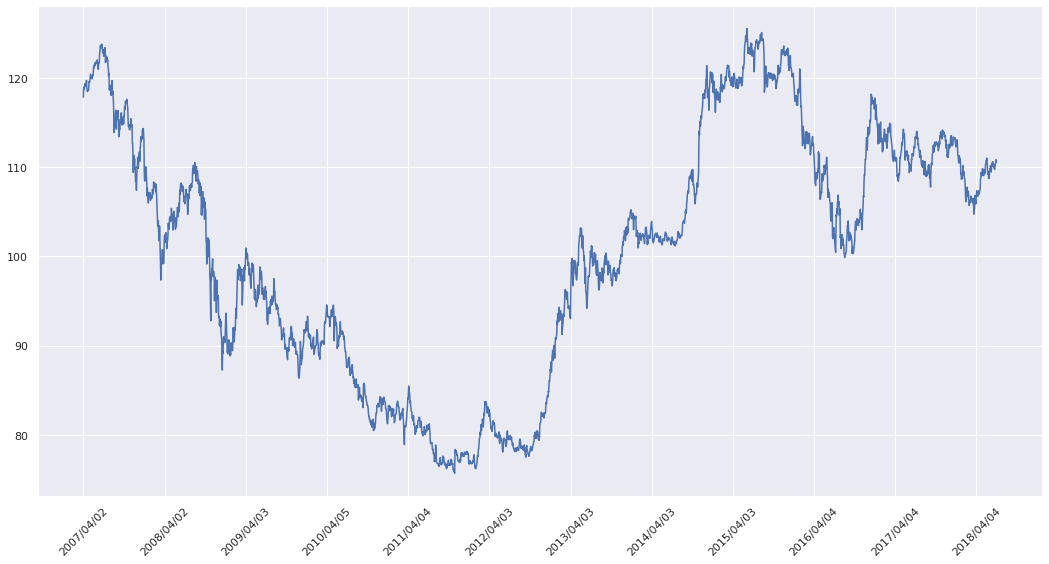

In [25]:
plt.figure(figsize = (18,9))
plt.plot(np.arange(df.shape[0]), df['終値'].values)
plt.xticks(np.arange(0, df.shape[0], 260), df['日付'].loc[::260], rotation=45)

In [26]:
close_prices = df['終値'].values

train_ratio = 0.8
n_train = int(len(close_prices) * train_ratio)
train, test = close_prices[:n_train], close_prices[n_train:]
train = train.reshape(-1, 1)
test = test.reshape(-1, 1)

In [27]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [28]:
print(np.min(train))
print(train[32])
print(np.max(train))

0.0
[0.9051534]
1.0000000000000002


In [29]:
print(len(train))

2340


In [30]:
import math

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size, n_steps, input_size, output_size):
        self.data = data
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.input_size = input_size
        self.output_size = output_size

    def __len__(self):
        return math.floor((len(self.data) - self.n_steps) / self.batch_size)
    
    def __getitem__(self, idx):
        xs = np.zeros((self.batch_size, self.n_steps, self.input_size))
        ys = np.zeros((self.batch_size, self.output_size))

        for i in range(self.batch_size):
            step_begin = (idx * self.batch_size) + i
            step_end = (idx * self.batch_size) + i + self.n_steps
            x = np.zeros((self.n_steps, self.input_size))
            y = np.zeros((self.output_size))

            if step_end >= len(self.data):
                break
            else:
                x = self.data[step_begin: step_end]
                y = self.data[step_end]

            xs[i] = x
            ys[i] = y

        return xs, ys

In [31]:
# 学習設定
batch_size = 32    # ミニバッチサイズ
n_steps = 50       # 入力系列の長さ
input_size = 1     # 入力の次元
hidden_size = 50   #  中間層の次元
output_size = 1    # 出力層の次元

n_epochs = 30       # エポック数

In [32]:
train_gen = DataGenerator(train, batch_size, n_steps, input_size, output_size)

## モデル構築

In [33]:
def create_model():
    inputs = tf.keras.layers.Input(shape=(n_steps, input_size))
    lstm = tf.keras.layers.LSTM(hidden_size)(inputs)
    output = tf.keras.layers.Dense(output_size)(lstm)

    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics='accuracy')

    return model

model = create_model()

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50, 1)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


## 学習

In [34]:
model.fit_generator(train_gen, epochs=30, shuffle=True)

Epoch 1/30
71/71 [==============================] - 0s 6ms/step - loss: 0.0182 - accuracy: 8.8028e-04
Epoch 2/30
71/71 [==============================] - 0s 5ms/step - loss: 8.5033e-04 - accuracy: 8.8028e-04
Epoch 3/30
71/71 [==============================] - 0s 5ms/step - loss: 8.3647e-04 - accuracy: 8.8028e-04
Epoch 4/30
71/71 [==============================] - 0s 5ms/step - loss: 8.9750e-04 - accuracy: 8.8028e-04
Epoch 5/30
71/71 [==============================] - 0s 5ms/step - loss: 7.2595e-04 - accuracy: 8.8028e-04
Epoch 6/30
71/71 [==============================] - 0s 5ms/step - loss: 8.4951e-04 - accuracy: 8.8028e-04
Epoch 7/30
71/71 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 8.8028e-04
Epoch 8/30
71/71 [==============================] - 0s 5ms/step - loss: 8.7995e-04 - accuracy: 8.8028e-04
Epoch 9/30
71/71 [==============================] - 0s 5ms/step - loss: 0.0021 - accuracy: 8.8028e-04
Epoch 10/30
71/71 [==============================] - 0s 5m

## テスト

In [35]:
test_gen = DataGenerator(test, batch_size, n_steps, input_size, output_size)
predicts = model.predict_generator(test_gen)

In [36]:
fixed_predicts = scaler.inverse_transform(predicts)
fixed_test = scaler.inverse_transform(test)

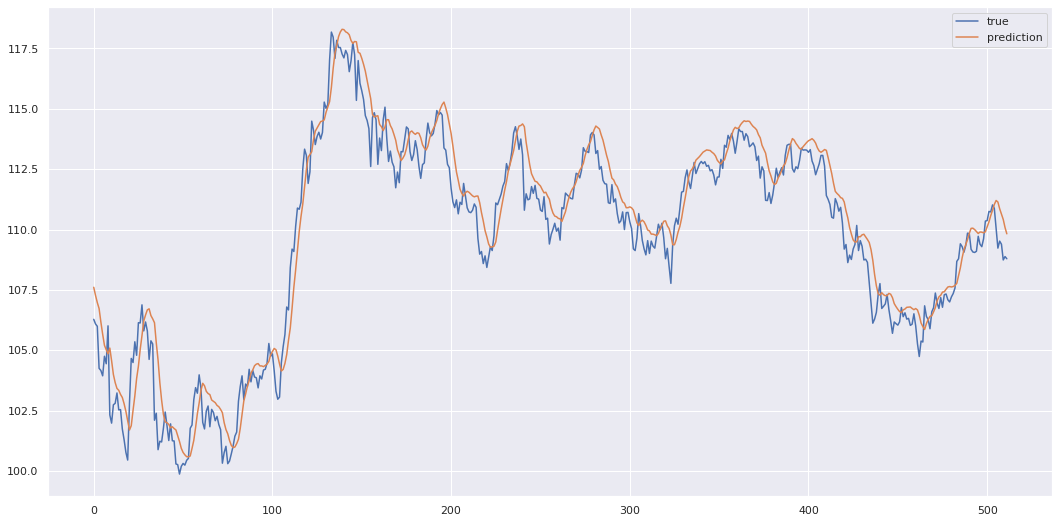

In [37]:
# テストデータに対する予測を可視化
mod = (len(fixed_test) - n_steps) % batch_size
xx = np.arange(len(fixed_predicts))
plt.figure(figsize=(18, 9))
plt.plot(xx, fixed_test[n_steps:-mod], label='true')
plt.plot(xx, fixed_predicts, label='prediction')
plt.legend()